# Facial Expression Detection Using CNN

## Importing necessary libraries and packages

In [2]:
import numpy as np
import pandas as pd
import math
import scikitplot
import cv2
import seaborn as sns
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras.utils


### Loading the Data

In [35]:
df = pd.read_csv('fer2013.csv')

In [36]:
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Data Pre-processing

In [37]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [38]:
# Define emotions labels
emotions_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [39]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [41]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

In [42]:
# Preprocessing function

def preprocess_data(df):

    # Extract pixel values and labels
    pixels = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
    labels = df['emotion']

    # Convert pixels to 48x48 images
    img_array = np.vstack(pixels) / 255.0
    img_array = img_array.reshape(-1, 48, 48, 1)  # Reshape to (num_samples, height, width, channels)

    # Shuffle the data
    np.random.seed(42)  # Set random seed for reproducibility
    shuffled_indices = np.arange(img_array.shape[0])
    np.random.shuffle(shuffled_indices)
    img_array = img_array[shuffled_indices]
    labels = labels.iloc[shuffled_indices]

    # Encode labels
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    labels_encoded = pd.get_dummies(labels_encoded).values  # One-hot encode labels

    return img_array, labels_encoded

In [43]:
# Preprocess the data
img_features, img_labels = preprocess_data(df)

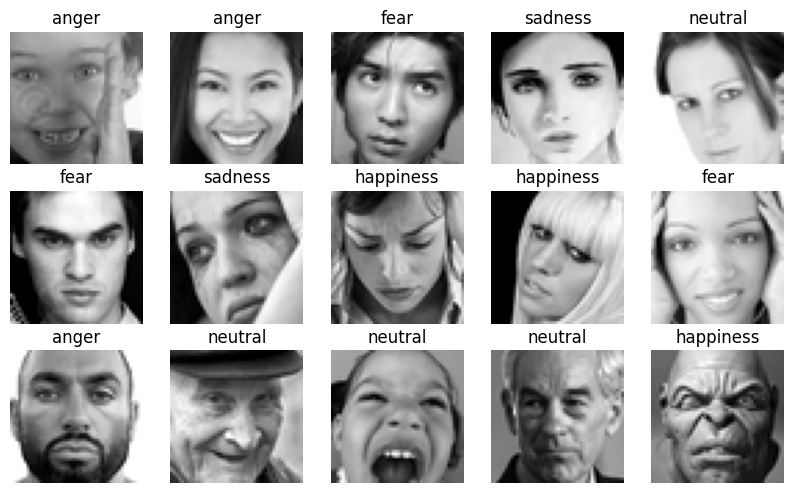

In [44]:
# Visualize some sample preprocessed images
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.imshow(img_features[i].reshape(48, 48), cmap='gray')
    plt.title(emotions_labels[df['emotion'].iloc[i]])
    plt.axis('off')
plt.show()



### Train test validation split

In [45]:
# Train and Test split of data
X_train, X_valid, y_train, y_valid = train_test_split(img_features, img_labels, shuffle=True, stratify=img_labels, test_size=0.1, random_state=42)


In [46]:
# Normalize the data
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [47]:
# Print the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (32298, 48, 48, 1)
y_train shape: (32298, 7)
X_valid shape: (3589, 48, 48, 1)
y_valid shape: (3589, 7)


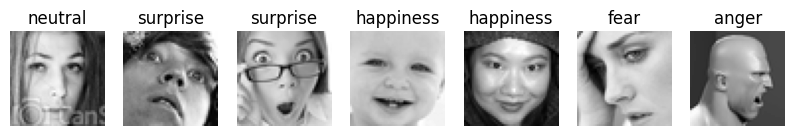

In [48]:
# Function to plot sample images
def plot_sample_images(images, labels, emotions_labels, num_samples=7):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i][:, :, 0], cmap='gray')
        plt.title(emotions_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

# Plot sample images
plot_sample_images(X_train, y_train, emotions_labels, num_samples=7)

### Data Augmentation to prevent overfitting

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

valgen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

In [50]:
datagen.fit(X_train)
valgen.fit(X_valid)

In [51]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = valgen.flow(X_valid, y_valid, batch_size=64)

## Building a CNN model

In [52]:
# Building model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # 7 output classes
])


c:\python 3.11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,079 (3.86 MB)

 Trainable params: 1,011,079 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

##### Adding checkpointer to implement Early Stopping to prevent overfitting

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath to save the best model
filepath = "best_model.keras"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss',  # Monitor validation loss
                             verbose=1, 
                             save_best_only=True,  # Save only the best model
                             mode='min')  # Minimize validation loss



In [56]:
# Training the model with the ModelCheckpoint callback
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [57]:
# Train the model with the ModelCheckpoint callback
history = model.fit(train_generator,
                    epochs= 50,
                    batch_size=64,
                    verbose = 1,
                    validation_data=val_generator,
                    callbacks=[checkpoint])  # Pass the ModelCheckpoint callback

Epoch 1/50
  1/505 ━━━━━━━━━━━━━━━━━━━━ 12:46 2s/step - accuracy: 0.0938 - loss: 1.9459

c:\python 3.11\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2481 - loss: 1.8266
Epoch 1: val_loss improved from inf to 1.81250, saving model to fer_best.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.2481 - loss: 1.8266 - val_accuracy: 0.2505 - val_loss: 1.8125
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2494 - loss: 1.8139
Epoch 2: val_loss improved from 1.81250 to 1.81166, saving model to fer_best.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.2494 - loss: 1.8139 - val_accuracy: 0.2505 - val_loss: 1.8117
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2524 - loss: 1.8111
Epoch 3: val_loss improved from 1.81166 to 1.81068, saving model to fer_best.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.2524 - loss: 1.8111 - val_accuracy: 0.2505 - val_loss: 1.8107
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2512 - loss: 1.8132
Epoch 4: val_loss improved from 1.81068 to 1.81009, saving mo

#### Visualizing Results

In [58]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2545 - loss: 1.8050
Validation Loss: 1.809187650680542
Validation Accuracy: 0.2504875957965851


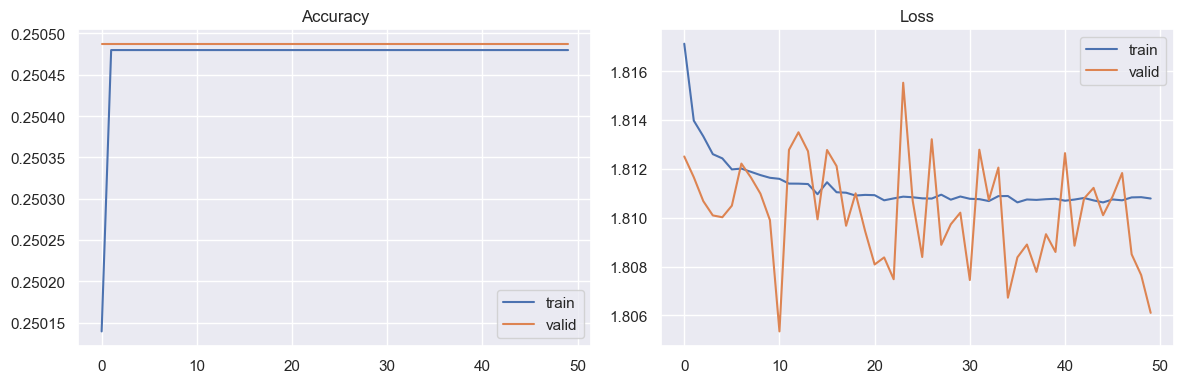

In [59]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

In [7]:
# Load the saved model
saved_model = tf.keras.models.load_model("best_model.keras")


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


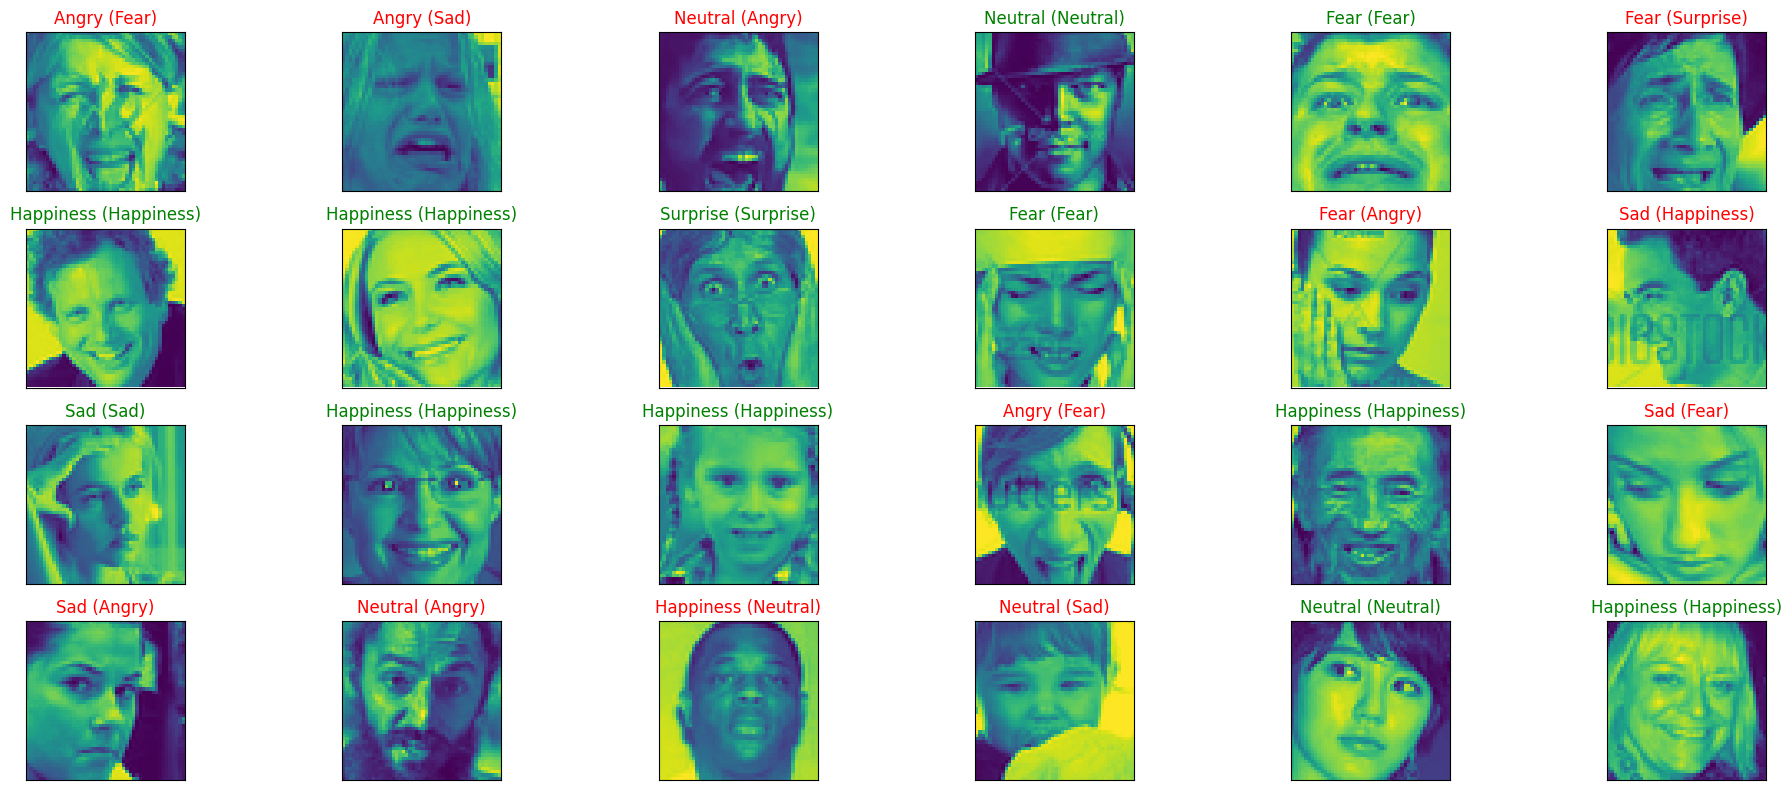

In [24]:
# Define a dictionary mapping class indices to class labels
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Make predictions on the validation set
preds = saved_model.predict(X_valid)
y_pred = np.argmax(preds, axis=1)

# Visualize the predictions alongside the corresponding input images
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_valid.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_valid[index]))
    
    # Get the predicted and true class labels
    predict_index = label_dict[y_pred[index]]
    true_index = label_dict[np.argmax(y_valid, axis=1)[index]]
    
    # Set the title with the predicted and true labels, highlighting correct predictions in green and incorrect ones in red
    ax.set_title("{} ({})".format(predict_index, true_index), color=("green" if predict_index == true_index else "red"))

plt.tight_layout()
plt.show()


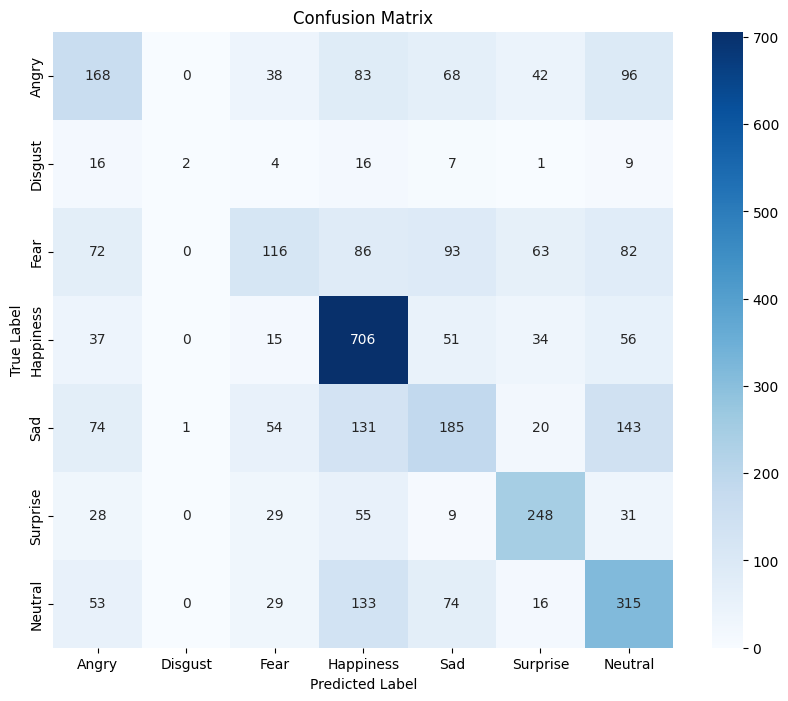

<Figure size 640x480 with 0 Axes>

In [25]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_valid, axis=1), y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("confusion_matrix_best.png")

In [26]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_valid, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.375     0.339     0.356       495
           1      0.667     0.036     0.069        55
           2      0.407     0.227     0.291       512
           3      0.583     0.785     0.670       899
           4      0.380     0.304     0.338       608
           5      0.585     0.620     0.602       400
           6      0.430     0.508     0.466       620

    accuracy                          0.485      3589
   macro avg      0.490     0.403     0.399      3589
weighted avg      0.470     0.485     0.464      3589

